### Data Augmentation

In this notebook data augmentation is performed for improving the performances of the ConvLSTM model. 

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2\models
c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2


In [2]:
import importlib
import torch
import copy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.ConvLSTM_pytorch.multistep_convlstm import MultiStepConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from pre_processing.augmentation import *
from post_processing.cool_animation import plot_animation
from post_processing.plots import *

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/conv_lstm_4batch_32hidden_3kernel_48_layers_augmentation.pth'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [7]:
# # Split dataset into train and validation
# train_percnt = 0.8
# train_size = int(train_percnt * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_set, val_set = random_split(train_dataset, [train_size, val_size])

In [8]:
transformed_dataset = augmentation(train_dataset, p_hflip=0.5, full=True)

The samples in the dataset before augmentation were 80
The samples in the dataset after augmentation are 160


In [9]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_set, val_set = random_split(transformed_dataset, [train_size, val_size])

In [10]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_wd, scaler_q = scaler(train_set)

normalized_train_dataset = normalize_dataset(train_set, scaler_x, scaler_wd, scaler_q, train_val)
normalized_val_dataset = normalize_dataset(val_set, scaler_x, scaler_wd, scaler_q, train_val)

In [11]:
# Model
# model = MultiStepConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], 
#                           hidden_dim = 8, kernel_size = (3, 3), num_layers = 8, batch_first=True, bias=True, return_all_layers = False).to(device)

model = ConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], hidden_dim = 32, kernel_size = (3, 3),
                 num_layers = 48, batch_first=True, bias=True, return_all_layers = True).to(device)

# return all layers has to be true to obtain all the outputs I think
# num_layers refers to the number of cells and thus outputs
# Number of outputs = 4 gates * hidden_dim

In [12]:
model

ConvLSTM(
  (conv2): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(36, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-47): 47 x ConvLSTMCell(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [13]:
# Set training parameters
learning_rate = 0.005
batch_size = 4 # Only have 64 and 16 samples for training and validation, I think should be kept small, having issues where this only works if set to 1
num_epochs = 500 #1_000

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [14]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device)

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    count += 1
    
    if epoch%100 == 0:
        print(f"Epoch: {epoch} " +
              f"\t Training loss: {train_loss: .2e} " + 
              f"\t Validation loss: {val_loss: .2e} " +
              f"\t Best validation loss: {best_loss: .2e}")
    if count > 300:
        print(f"Loss Stagnated for 300 epochs, early stopping initiated")
        break

Epoch: 100 	 Training loss:  4.29e-02 	 Validation loss:  4.26e-02 	 Best validation loss:  4.03e-02
Epoch: 200 	 Training loss:  4.24e-02 	 Validation loss:  4.29e-02 	 Best validation loss:  3.82e-02
Epoch: 300 	 Training loss:  4.27e-02 	 Validation loss:  4.29e-02 	 Best validation loss:  3.82e-02
Epoch: 400 	 Training loss:  4.27e-02 	 Validation loss:  4.30e-02 	 Best validation loss:  3.82e-02
Loss Stagnated for 300 epochs, early stopping initiated


In [15]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

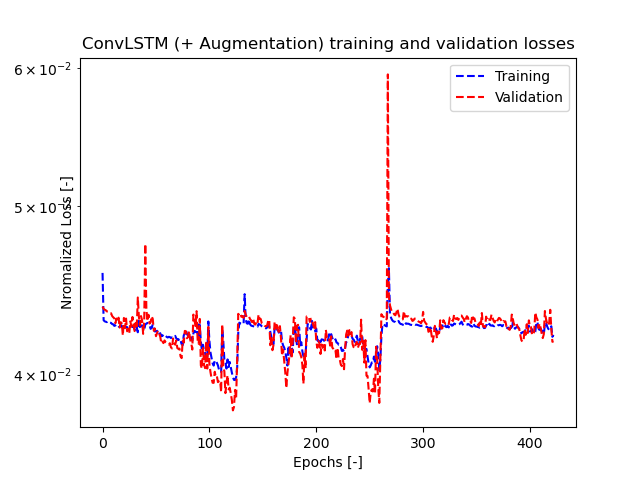

In [16]:
plot_losses(train_losses, val_losses, 'ConvLSTM (+ Augmentation) ')

In [17]:
# def bello(sample, dataset, model, train_val, scaler_x,
#                    scaler_wd, scaler_q, device='cuda', save=False):

#     # Extracting information from the dataset
#     input = dataset[sample][0]
#     target = dataset[sample][1]
#     boundary_condition = input[0][3]
    
#     time_steps = target.shape[0]

#     # Denormalizing the data for plotting
#     elevation, water_depth, discharge = denormalize_dataset(
#         input, target, train_val, scaler_x, scaler_wd, scaler_q)
    
#     print(f'Elevation shape: {elevation.shape}, type: {type(elevation)}')
#     print(f'water_depth shape: {water_depth.shape}, type: {type(water_depth)}')
#     print(f'discharge shape: {discharge.shape}, type: {type(discharge)}')

#     return None

In [18]:
# bello(10, normalized_train_dataset, model, train_val,
#                scaler_x, scaler_wd, scaler_q, device = device, save = False)

In [19]:
normalized_train_dataset[0][1].shape

torch.Size([48, 2, 64, 64])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


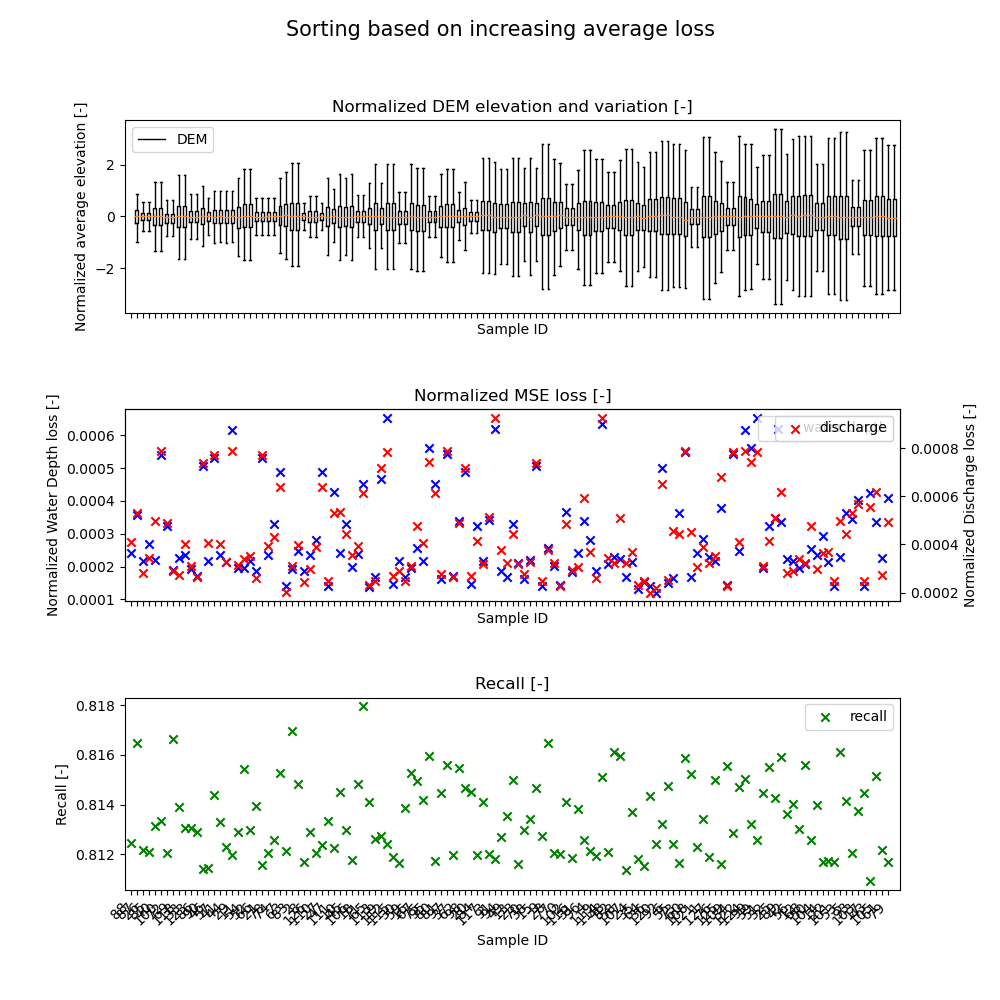

In [84]:
plot_sorted(normalized_train_dataset, train_val, scaler_x, scaler_wd, scaler_q, model, device)